In [40]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.utils.validation import check_is_fitted
import plotly.express as px

# Custom written utilities for analysis/modelling/feature engineering
from utils import FeatureImportance, pre_process, get_scores
import pickle
import plotly.io as pio
pio.renderers.default = "svg"

## Load data downloaded from S3

In [4]:
# Run this incase data is not loaded via bash script
# !wget https://s3-us-west-2.amazonaws.com/pcadsassessment/parking_citations.corrupted.csv

In [5]:
df = pd.read_csv("parking_citations.corrupted.csv")

/tmp/ipykernel_643/2998227632.py:1: DtypeWarning:

Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
df.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,NaN,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,NaN,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NaN,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,NaN,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0


In [7]:
df.describe()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude
count,8.723431e+06,290599.000000,7.931187e+06,8.725469e+06,8.719507e+06,8.726011e+06,8.726011e+06
mean,1.203930e+03,1055.399286,1.867823e+05,5.200932e+01,7.011293e+01,5.501648e+06,1.586792e+06
std,4.722413e+02,227.596205,5.276278e+04,9.301675e+00,3.211512e+01,3.004177e+06,2.065458e+06
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+01,9.999900e+04,9.999900e+04
25%,9.120000e+02,910.000000,2.016010e+05,5.100000e+01,6.300000e+01,6.421512e+06,1.821558e+06
50%,1.156000e+03,1035.000000,2.017020e+05,5.400000e+01,6.800000e+01,6.451540e+06,1.841987e+06
75%,1.511000e+03,1200.000000,2.018030e+05,5.500000e+01,7.300000e+01,6.475013e+06,1.858207e+06
max,2.359000e+03,2400.000000,8.201080e+05,9.700000e+01,5.050000e+02,4.042322e+09,4.042322e+09


In [8]:
# Finding Top 25 Make based on number of rows
pd_df = df.groupby("Make")['Ticket number'].count().reset_index(name="count").sort_values("count",ascending=False)[:25]
pd_df.head()

,Make,count
1331,TOYT,721411
506,HOND,491961
384,FORD,382695
942,NISS,311324
180,CHEV,297076


In [9]:
# Creating the binary variable indicating whether popular Make or not
popularMakes = pd_df["Make"].values.tolist()
df['popularMakeorNot'] = df['Make'].apply(lambda x: 1 if x in popularMakes else 0,1)
df

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,popularMakeorNot
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,NaN,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,9.999900e+04,9.999900e+04,0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,NaN,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,9.999900e+04,9.999900e+04,0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NaN,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6.439998e+06,1.802686e+06,0
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,NaN,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6.440041e+06,1.802686e+06,0
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,9.999900e+04,9.999900e+04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8726009,4347602394,2019-01-10T00:00:00,1245.0,VN686B,NaN,CA,201905.0,NaN,NaN,PA,WT,14301 DELANO ST,00300,53.0,88.13B+,METER EXP.,63.0,6.427279e+06,1.889149e+06,0
8726010,4347602405,2019-01-10T00:00:00,1350.0,VN316,NaN,CA,201905.0,NaN,HYUN,PA,SL,14500 FRIAR ST,00300,53.0,88.13B+,METER EXP.,63.0,6.425963e+06,1.890254e+06,1
8726011,4347602416,2019-01-10T00:00:00,1354.0,VN914,NaN,CA,201912.0,NaN,NISS,PA,GY,14400 FRIAR ST,00300,53.0,88.13B+,METER EXP.,63.0,6.426623e+06,1.890252e+06,1
8726012,4347602420,2019-01-10T00:00:00,1411.0,VN725,NaN,CA,201903.0,NaN,NaN,PA,GY,6300 SYLMAR AV,00300,53.0,88.13B+,METER EXP.,63.0,6.426622e+06,1.889882e+06,0


In [10]:
# Based on task description, separating corrupted rows (having NA values for Make column) as test and rest as training set
df_train = df[~df.Make.isna()]
df_test = df[df.Make.isna()]

In [11]:
del df

## EDA

In [12]:
# Uncorrupted dataframe with valid make values
df = df_train

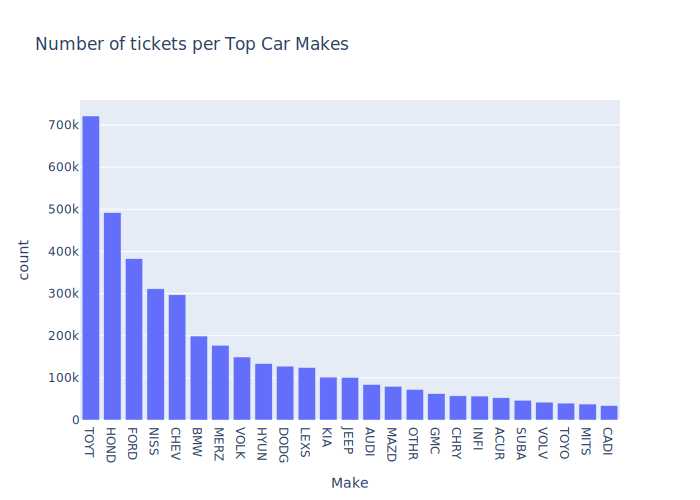

In [13]:
pd_df = df.groupby("Make")['Ticket number'].count().reset_index(name="count").sort_values("count",ascending=False)[:25]
px.bar(pd_df,x="Make",y="count",title="Number of tickets per Top Car Makes")

In [14]:
# % of null values per column
100*df.isna().sum()/len(df)

# Marked time + Marked Id + VIN are mostly empty so they can be dropped.

Ticket number             0.000000
Issue Date                0.000000
Issue time                0.022834
Meter Id                 73.979632
Marked Time              96.674228
RP State Plate            0.008973
Plate Expiry Date         9.100241
VIN                      99.813152
Make                      0.000000
Body Style                0.091565
Color                     0.034744
Location                  0.003419
Route                     0.726946
Agency                    0.000138
Violation code            0.000000
Violation Description     0.009891
Fine amount               0.073321
Latitude                  0.000023
Longitude                 0.000023
popularMakeorNot          0.000000
dtype: float64

In [15]:
df.describe()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude,popularMakeorNot
count,4.356549e+06,144922.000000,3.960997e+06,4.357538e+06,4.354349e+06,4.357543e+06,4.357543e+06,4.357544e+06
mean,1.203880e+03,1055.147196,1.867826e+05,5.203218e+01,7.010876e+01,5.503485e+06,1.587400e+06,9.147846e-01
std,4.722652e+02,227.166905,5.276190e+04,9.238550e+00,3.205594e+01,3.025596e+06,2.098413e+06,2.792020e-01
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+01,9.999900e+04,9.999900e+04,0.000000e+00
25%,9.120000e+02,910.000000,2.016010e+05,5.100000e+01,6.300000e+01,6.421524e+06,1.821596e+06,1.000000e+00
50%,1.155000e+03,1036.000000,2.017020e+05,5.400000e+01,6.800000e+01,6.451586e+06,1.841993e+06,1.000000e+00
75%,1.511000e+03,1200.000000,2.018030e+05,5.500000e+01,7.300000e+01,6.475013e+06,1.858208e+06,1.000000e+00
max,2.359000e+03,2400.000000,5.015120e+05,9.700000e+01,5.050000e+02,4.042322e+09,4.042322e+09,1.000000e+00


In [16]:
# Checking if some variables are correlated with each other for continous variables 
df.corr()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude,popularMakeorNot
Issue time,1.000000,0.796187,0.015258,-0.044840,-0.007937,0.037449,0.015635,-0.006936
Marked Time,0.796187,1.000000,0.104674,-0.049865,0.013390,-0.033271,-0.035778,-0.012132
Plate Expiry Date,0.015258,0.104674,1.000000,-0.069531,-0.027864,-0.010927,-0.003974,0.056664
Agency,-0.044840,-0.049865,-0.069531,1.000000,-0.035432,0.148542,0.058981,0.037669
Fine amount,-0.007937,0.013390,-0.027864,-0.035432,1.000000,-0.002571,-0.001090,-0.006868
Latitude,0.037449,-0.033271,-0.010927,0.148542,-0.002571,1.000000,0.854439,0.009859
Longitude,0.015635,-0.035778,-0.003974,0.058981,-0.001090,0.854439,1.000000,0.004334
popularMakeorNot,-0.006936,-0.012132,0.056664,0.037669,-0.006868,0.009859,0.004334,1.000000


In [17]:
# Number of unique values per column
df.nunique()

Ticket number            4357544
Issue Date                  1724
Issue time                  1440
Meter Id                   36456
Marked Time                 1111
RP State Plate                77
Plate Expiry Date            709
VIN                         4948
Make                        1477
Body Style                   145
Color                         80
Location                 1047757
Route                       6795
Agency                        38
Violation code               282
Violation Description        600
Fine amount                   36
Latitude                  704931
Longitude                 697788
popularMakeorNot               2
dtype: int64

In [18]:
# Given how number of unique values are pretty high, we might 
# have to select categoricals to consider which might be useful.

# Preprocessing time related issue date which can be used to find day, week, month 
# that can be helpful features

# Parsing Hour from Issue which is a integer
df["IssueHour"] = (
        df["Issue time"]
        .apply(lambda x: int(x) // 100 if pd.notnull(x) else x, 1)
        .astype("category")
    )

# Parse into datetime object
df["IssueDateObj"] = pd.to_datetime(df["Issue Date"])
df["IssueWeek"] = df["IssueDateObj"].dt.isocalendar().week
df["IssueMonth"] = df["IssueDateObj"].dt.month
df["IssueYear"] = df["IssueDateObj"].dt.year
df["IssueWeekDay"] = df["IssueDateObj"].dt.weekday
df["IssueDay"] = df["IssueDateObj"].dt.day



/tmp/ipykernel_643/3669827805.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_643/3669827805.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_643/3669827805.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_643/3

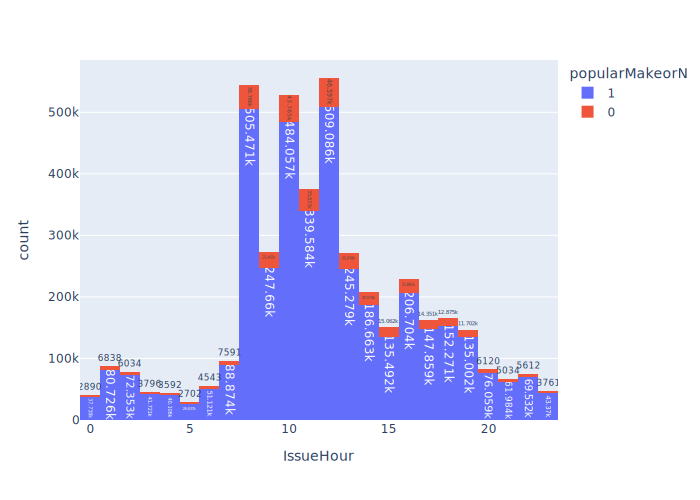

In [19]:
# Which hour do most tickets get filed?
# pd_df = df.groupby("IssueHour")["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)
px.histogram(df,x="IssueHour",text_auto=True,color="popularMakeorNot",barmode="stack")

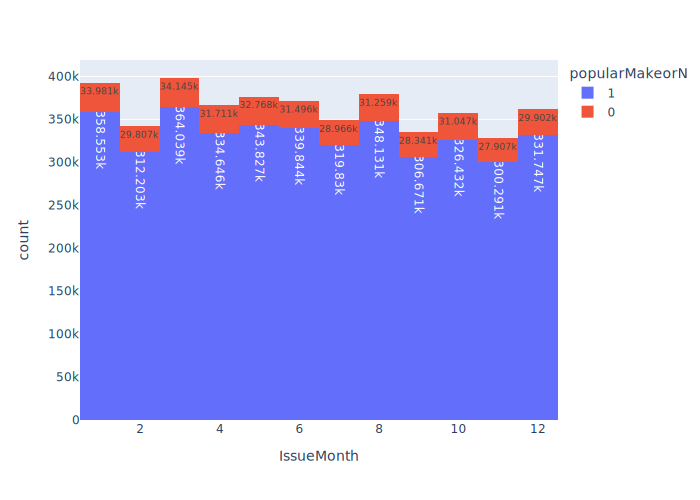

In [20]:
# Which month do most tickets get filed?
px.histogram(df,x="IssueMonth",text_auto=True,color="popularMakeorNot",barmode="stack")
# More or less it's uniform across months

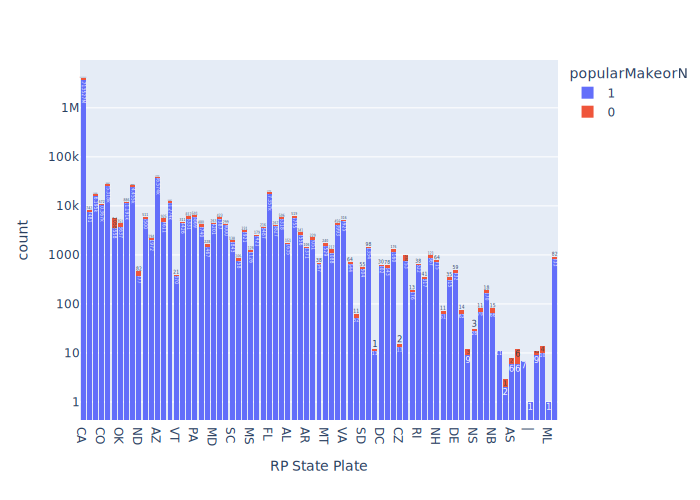

In [21]:
px.histogram(df,x="RP State Plate",text_auto=True,color="popularMakeorNot",barmode="stack",log_y=True)
# This is quite shocking that quite a lot pf data is from California State plates by a logarithmic margin
# It makes sense to use this variable in model

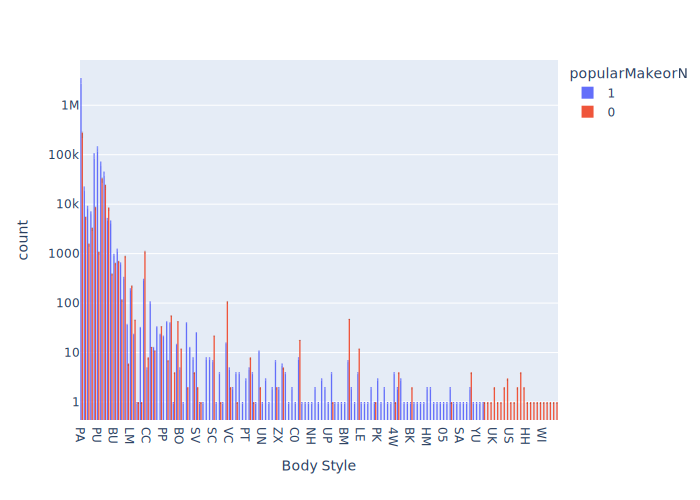

In [22]:
px.histogram(df,x="Body Style",text_auto=True,color="popularMakeorNot",barmode="group",log_y=True)
# This is quite shocking that quite a lot data is for "PA" body style. It makes sense to use a binary variable for that particular body style/
# Also see there is a separation between

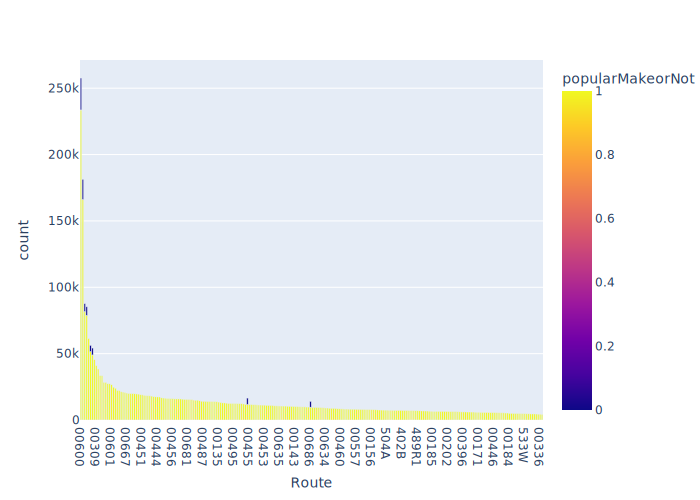

In [23]:
pd_df = df.groupby(["Route","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)[:250]
px.bar(pd_df,x="Route",y="count",color="popularMakeorNot")

# We can see how one of the routes dominate all others so maybe that can help as a individual feature
# Therefore we can combine other categories with less frequency into "Other" i.e. bottom 1% percent for instance with others

/tmp/ipykernel_643/3799580334.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



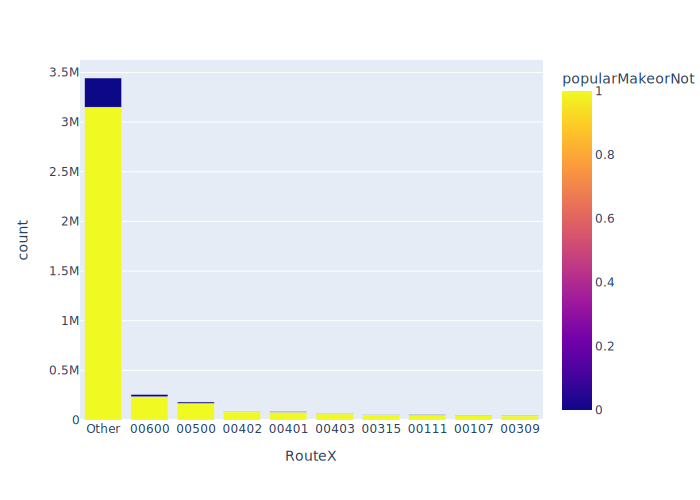

In [24]:
feature = "Route"
df["RouteX"] = df[feature].mask(df[feature].map(df[feature].value_counts(normalize=True)) < 0.01, 'Other')
pd_df = df.groupby(["RouteX","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)

px.bar(pd_df,x="RouteX",y="count",color="popularMakeorNot")

# As it can be seen, it reduces down the categoricals into just 20 after combining below 1% as Others


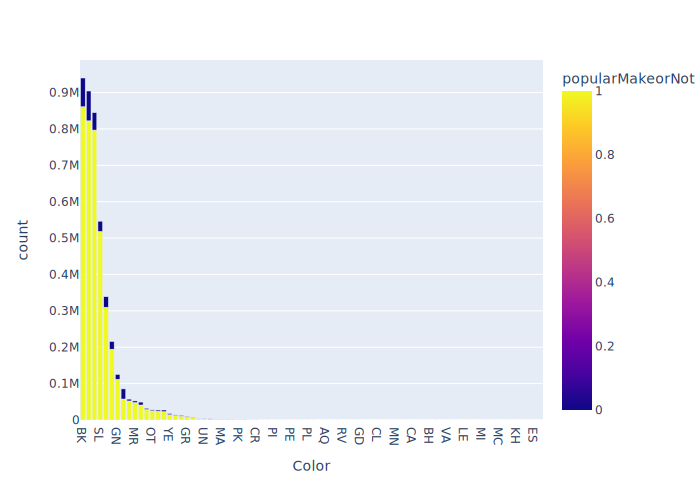

In [25]:
pd_df = df.groupby(["Color","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)[:500]
px.bar(pd_df,x="Color",y="count",color="popularMakeorNot")

# We can see top ones are more and it's long tailed distribution, so combining lower ferquency ones into Other

/tmp/ipykernel_643/2466721373.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



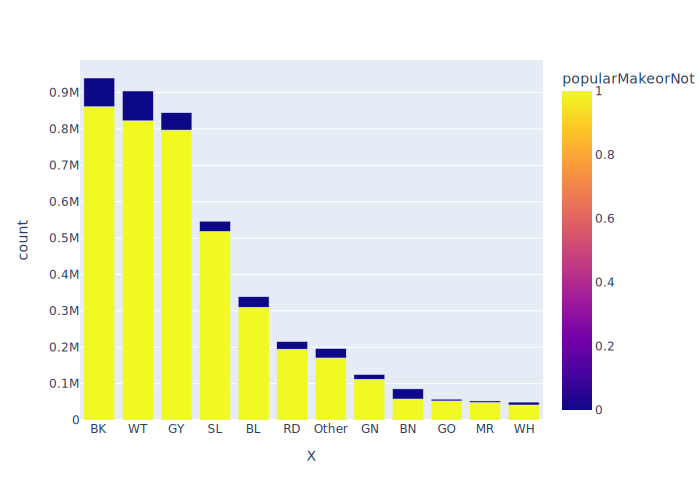

In [26]:
feature = "Color"
df["X"] = df[feature].mask(df[feature].map(df[feature].value_counts(normalize=True)) < 0.01, 'Other')
pd_df = df.groupby(["X","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)

px.bar(pd_df,x="X",y="count",color="popularMakeorNot")

# As it can be seen, it reduces down the categoricals into just 20 after combining below 1% as Others


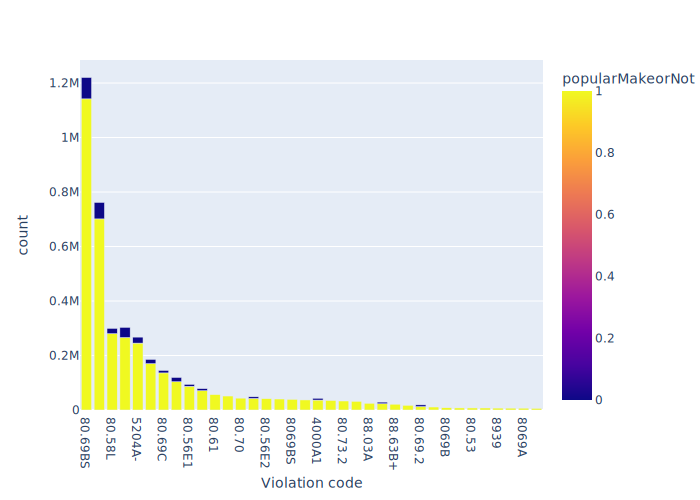

In [27]:
pd_df = df.groupby(["Violation code","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)[:50]
px.bar(pd_df,x="Violation code",y="count",color="popularMakeorNot")

# We can see top ones are more and it's long tailed distribution, so combining lower ferquency ones into Other

/tmp/ipykernel_643/3940758133.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



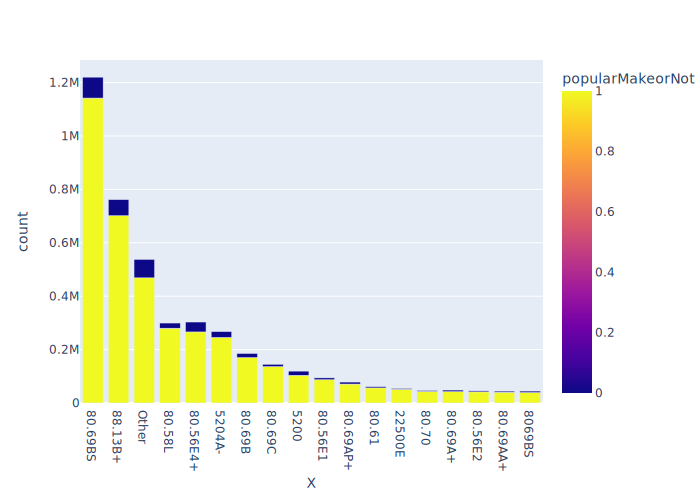

In [28]:
feature = "Violation code"
df["X"] = df[feature].mask(df[feature].map(df[feature].value_counts(normalize=True)) < 0.01, 'Other')
pd_df = df.groupby(["X","popularMakeorNot"])["Ticket number"].count().reset_index(name="count").sort_values("count",ascending=False)

px.bar(pd_df,x="X",y="count",color="popularMakeorNot")

# As it can be seen, it reduces down the categoricals into just 20 after combining below 1% as Others


## Feature Engineering + Modelling

In [29]:
# Primary Features cps
feats = ['Issue Date', 'Issue time',
       'RP State Plate', 'Body Style',
       'Color', 'Agency', 'Violation code',
         "Route",'Fine amount', 'Latitude', 'Longitude']
out = ["popularMakeorNot"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_train[feats], df_train[out], test_size=0.33, random_state=42,stratify=df_train[out])

In [31]:
# Categorical features
cat_cols = ['RP State Plate', 'Body Style', 'Color', 'Agency', 'Violation code',"Route",
        'IssueHour', 'IssueWeek', 'IssueYear', 'IssueWeekDay', 'IssueDay']

In [33]:
X_trainN = pre_process(X_train,cat_cols)
X_testN = pre_process(X_test,cat_cols)

In [34]:
missing_num_vars = ["Latitude","Longitude","Fine amount"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer =Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("one-hot encoder", 
 OneHotEncoder(handle_unknown="ignore"))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, missing_num_vars),
        ("cat", categorical_transformer, cat_cols),
    ],remainder='passthrough'
)

In [35]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42,max_depth=2,max_features=8,n_jobs=4,verbose=1))]
)

In [36]:
%%time
clf.fit(X_trainN,y_train.values)

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:346: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.3s


CPU times: user 1min 21s, sys: 8.42 s, total: 1min 29s
Wall time: 34.7 s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   19.9s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Fine amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot '
                                       

In [37]:
%%time

y_pred = clf.predict(X_trainN)
print(f"\n ######## Train set metrics ###### \n")
get_scores(y_train.values,y_pred)


y_pred = clf.predict(X_testN)
print(f"\n ######## Test set metrics ###### \n")
get_scores(y_test.values,y_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.2s finished



 ######## Train set metrics ###### 

Accuracy: 0.9147845869608852
F1 score: 0.9554960836746824
Recall: 1.0
Precision: 0.9147845869608852


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished



 ######## Test set metrics ###### 

Accuracy: 0.9147845256225704
F1 score: 0.9554960502149855
Recall: 1.0
Precision: 0.9147845256225704
CPU times: user 37.4 s, sys: 4.99 s, total: 42.4 s
Wall time: 24.8 s


## Model Explanations + Strength/Weakness + Feasability 

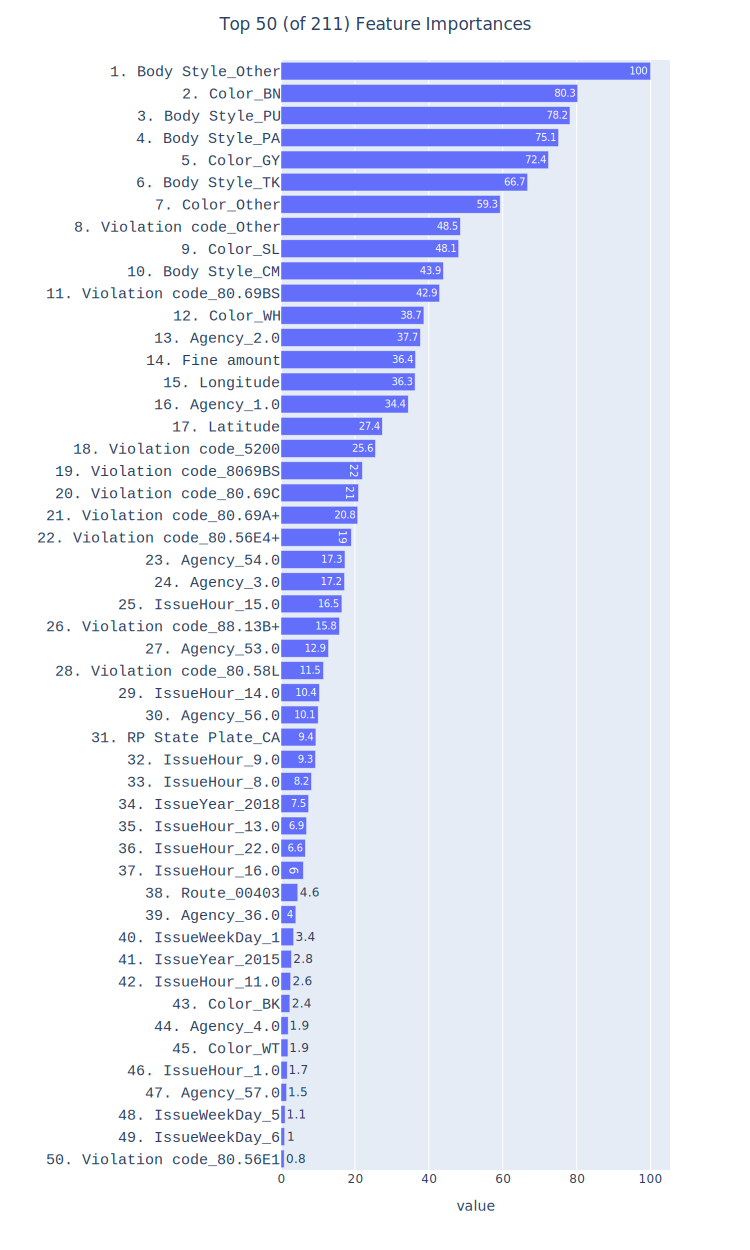

In [38]:
feature_importance = FeatureImportance(clf)
feature_importance.plot(top_n_features=50)

It can be seen from feature importance how certain violation codes, body style and routes play a major role in determining whether a Make is popular or not whic makes sense inituitevly as well.

Also model accuracy+precision,recall metrics for training and test are almost same which indicates that there's not much overfitting in the model. Since we are using basic Random Forest model it can be deployed easily using the pickle file and nothing complicated.


We can say that for the task of predicitng popular make for corrupted data it should work pretty great since it works well for unseen test split we created. Furthermore, it has high precision as well as recall given we have high F-score.
Although we would also say since data is imbalanced (1->90% and 0->10%) it is relatively easy to predict that make is popular so error should be low by default.

In [39]:
# Save model for making prediciton using server.py
pickle.dump(clf, open('model.pkl', 'wb'))